┌───┐┌────────┐                            statevector 
q_0: ┤ X ├┤ Rx(30) ├─■───────────────────────────────░──────
     ├───┤├────────┤ │ZZ(30)                         ░      
q_1: ┤ X ├┤ Rx(30) ├─■────────■──────────────────────░──────
     └───┘└────────┘          │                      ░      
q_2: ─────────────────────────┼──────────────────────░──────
     ┌───┐┌────────┐          │ZZ(30)                ░      
q_3: ┤ X ├┤ Rx(30) ├──────────■────────■─────────────░──────
     ├───┤├────────┤                   │ZZ(30)       ░      
q_4: ┤ X ├┤ Rx(30) ├───────────────────■─────────────░──────
     └───┘└────────┘                                 ░

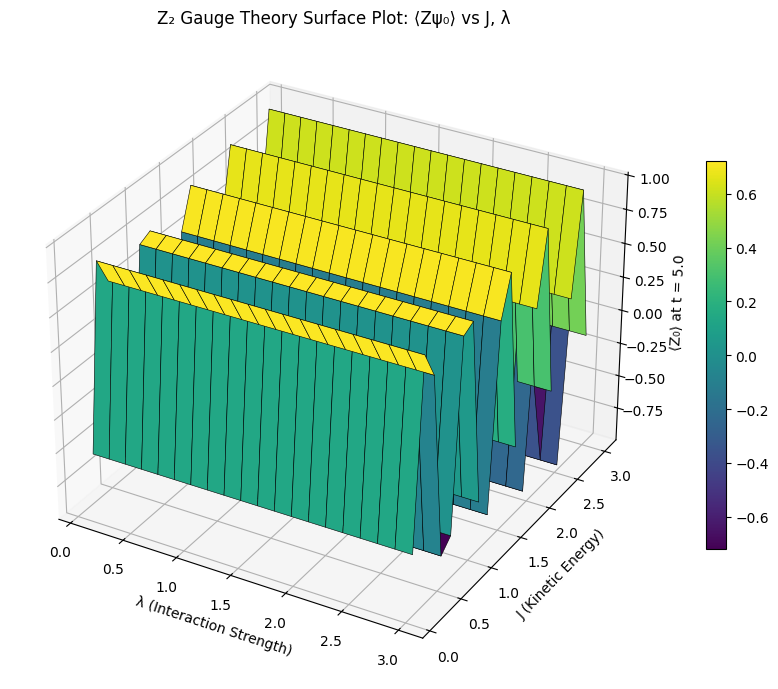

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, Pauli

# Parameters
t_fixed = 5.0  # Fixed time snapshot
n_J = 20
n_lambda = 20
J_values = np.linspace(0.1, 3.0, n_J)
lambda_values = np.linspace(0.1, 3.0, n_lambda)
Z0_surface = np.zeros((n_J, n_lambda))

backend = AerSimulator(method='statevector')

# Circuit builder
def build_circuit(t, J, lam):
    qc = QuantumCircuit(5)
    qc.x(0)  # ψ₀
    qc.x(1)  # U₀
    qc.x(3)  # U₁
    qc.x(4)  # ψ₂

    for q in [0, 1, 3, 4]:
        qc.rx(2 * J * t, q)

    qc.rzz(2 * lam * t, 0, 1)
    qc.rzz(2 * lam * t, 1, 3)
    qc.rzz(2 * lam * t, 3, 4)

    qc.save_statevector()
    return qc

# Run parameter sweep
for i, J in enumerate(J_values):
    for j, lam in enumerate(lambda_values):
        qc = build_circuit(t_fixed, J, lam)
        result = backend.run(qc).result()
        sv = result.data(0)['statevector']
        state = Statevector(sv)
        Z0_surface[i, j] = state.expectation_value(Pauli("ZIIII")).real

# Create 3D surface plot
from mpl_toolkits.mplot3d import Axes3D

J_grid, lambda_grid = np.meshgrid(lambda_values, J_values)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(J_grid, lambda_grid, Z0_surface, cmap='viridis', edgecolor='k', linewidth=0.4)
ax.set_xlabel('λ (Interaction Strength)')
ax.set_ylabel('J (Kinetic Energy)')
ax.set_zlabel('⟨Z₀⟩ at t = {:.1f}'.format(t_fixed))
ax.set_title("Z₂ Gauge Theory Surface Plot: ⟨Zψ₀⟩ vs J, λ")
fig.colorbar(surf, ax=ax, shrink=0.6)
plt.tight_layout()
# plt.show()
# plt.savefig('z2_sweep_3dplot.png', dpi=300, bbox_inches='tight')

qc.draw()